In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
font = {'family' : 'Arial',
        'size'   : 12}
matplotlib.rc('font', **font)

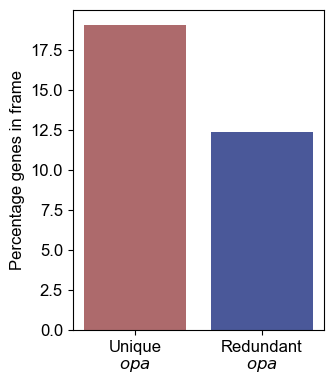

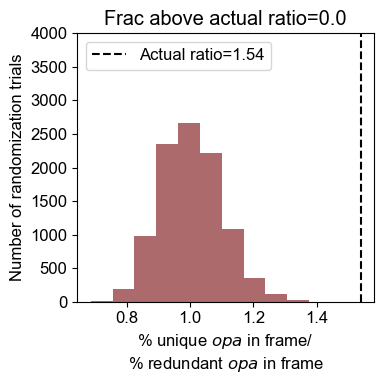

In [3]:
# Import metadata and calculate the number of repeats per opa gene
metadata = pd.read_csv('../../results/opa_metadata_locus.csv', index_col = 0)

metadata.dropna(subset = ['id'], inplace = True)
metadata.reset_index(inplace = True, drop = True)

# Checking if identical opas tend to have fewer repeats/tend to be more turned off

within_strain_distance = pd.read_csv('../../results/pairwise_distance/within_strain_pairwise_distance_aa.csv', index_col = 0)

similar_opas = np.unique(np.concatenate([within_strain_distance[within_strain_distance['distance']<=0.05]['id_A'].values, within_strain_distance[within_strain_distance['distance']<=0.05]['id_B'].values]))

metadata['similar_within_strain'] = 'N'
metadata.loc[metadata['id'].isin(similar_opas), 'similar_within_strain'] = 'Y'

similar_within_strain = []
percent_in_frame = []
i=0
for similar, df in metadata.groupby('similar_within_strain'):
    similar_within_strain.append(similar + '\n(n = ' + str(len(df)) + ')')
    percent_in_frame.append(100*df['in_frame'].sum()/len(df))
    i+=1

# Plot the percentage of in-frame opa stratified by whether they are redundant within an isolate or not
plt.figure(figsize = (3.5,4))
plt.bar(similar_within_strain, percent_in_frame, color = ['#ad6a6c', '#4a5899'])
plt.ylabel('Percentage genes in frame')
plt.xticks(ticks = [0,1], labels = ['Unique\n$opa$', 'Redundant\n$opa$'])
# plt.title('Similar opa within strain\n(>=95% aa sequence identity)')
plt.tight_layout()
plt.savefig('../../figures/frame/frame_on_by_similar_opa_within_strain.png', dpi = 300)
plt.savefig('../../figures/frame/frame_on_by_similar_opa_within_strain.pdf')
plt.show()

# Statistical test

metadata_N = metadata[metadata['similar_within_strain']=='N']
metadata_Y = metadata[metadata['similar_within_strain']=='Y']
ratio_N_Y = ((metadata_N['in_frame'].sum()/len(metadata_N))/(metadata_Y['in_frame'].sum()/len(metadata_Y)))

metadata_rand = metadata.copy()

num_trials = 10**4
ratio_rand_N_Y = []
for i in range(num_trials):
    metadata_rand['similar_within_strain']=metadata['similar_within_strain'].sample(frac = 1).values

    metadata_rand_N = metadata_rand[metadata_rand['similar_within_strain']=='N']
    metadata_rand_Y = metadata_rand[metadata_rand['similar_within_strain']=='Y']
    ratio_rand_N_Y.append(((metadata_rand_N['in_frame'].sum()/len(metadata_rand_N))/(metadata_rand_Y['in_frame'].sum()/len(metadata_rand_Y))))

frac_above_actual_ratio = np.sum(ratio_rand_N_Y>ratio_N_Y)/num_trials
plt.figure(figsize = (4,4))
plt.hist(ratio_rand_N_Y, color = '#ad6a6c')
plt.plot([ratio_N_Y, ratio_N_Y], [0,4000], 'k--', label = 'Actual ratio='+str(round(ratio_N_Y,2)))
plt.ylim([0,4000])
plt.xlabel('% unique $opa$ in frame/\n% redundant $opa$ in frame')
plt.ylabel('Number of randomization trials')
plt.title('Frac above actual ratio='+ str(frac_above_actual_ratio))
plt.legend()
plt.tight_layout()
plt.savefig('../../figures/frame/frame_on_by_similar_opa_within_strain_sig.png', dpi = 300)
plt.savefig('../../figures/frame/frame_on_by_similar_opa_within_strain_sig.pdf')
plt.show()